In [26]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras 
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob 
import pandas as pan
import matplotlib.pyplot as plotter

In [16]:
# Set the path to your training and testing folders
train_folder = 'archive/Train_Test_Valid/Train'
test_folder = 'archive/Train_Test_Valid/test'
validation_folder = 'archive/Train_Test_Valid/valid'

In [17]:
def get_paths_labels(folder_path, allowed_extensions=("jpg", "jpeg", "png")):
    filepaths = []
    labels = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(allowed_extensions):
                file_path = os.path.join(root, file)
                label = os.path.basename(os.path.dirname(file_path))
                filepaths.append(file_path)
                labels.append(label)

    df = pd.DataFrame({"path": filepaths, "label": labels})
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the DataFrame
    return df

import matplotlib.pyplot as plt

def visualize_prediction(test_image, true_label, predicted_label):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot the test image
    ax.imshow(test_image, cmap='gray')  # Adjust the cmap based on your image format
    ax.set_title(f'True Label: {true_label}, Predicted Label: {predicted_label}')

    # Unpack the predicted keypoints
    x_coords = predicted_label[0::2] * 224  # Assuming the model output is normalized to [0, 1]
    y_coords = predicted_label[1::2] * 224

    # Plot the predicted keypoints on the image
    ax.scatter(x_coords, y_coords, c='r', marker='o', s=10)

    # Turn off axis labels and ticks
    ax.axis('off')

    plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder

train_df = get_paths_labels(train_folder)
print(train_df.head())
train_labels = train_df['label'].tolist()
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

test_df = get_paths_labels(test_folder)
print(test_df.head())
test_labels = test_df['label'].tolist()
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)
print(test_labels_encoded)

                                                path                 label
0  archive/Train_Test_Valid/Train/lions_mane_jell...  lions_mane_jellyfish
1  archive/Train_Test_Valid/Train/blue_jellyfish/...        blue_jellyfish
2  archive/Train_Test_Valid/Train/compass_jellyfi...     compass_jellyfish
3  archive/Train_Test_Valid/Train/barrel_jellyfis...      barrel_jellyfish
4  archive/Train_Test_Valid/Train/barrel_jellyfis...      barrel_jellyfish
                                                path                    label
0  archive/Train_Test_Valid/test/compass_jellyfis...        compass_jellyfish
1  archive/Train_Test_Valid/test/mauve_stinger_je...  mauve_stinger_jellyfish
2  archive/Train_Test_Valid/test/barrel_jellyfish...         barrel_jellyfish
3  archive/Train_Test_Valid/test/blue_jellyfish/1...           blue_jellyfish
4  archive/Train_Test_Valid/test/barrel_jellyfish...         barrel_jellyfish
[3 5 1 2 1 2 3 3 3 4 3 2 2 4 5 4 3 0 0 1 2 4 2 1 0 5 5 5 3 5 1 4 4 4 2 4 5
 0 0 0]

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Agrega esto para dividir automáticamente entre entrenamiento y validación
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Cambia a 'categorical' para one-hot encoding
    subset='training'  # Especifica que es el conjunto de entrenamiento
)

validation_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Cambia a 'categorical' para one-hot encoding
    subset='validation'  # Especifica que es el conjunto de validación
)

Found 720 images belonging to 6 classes.


Found 180 images belonging to 6 classes.


In [34]:
print(train_generator)

In [20]:
# Build the specified model architecture
model = keras.models.Sequential([
    layers.Flatten(input_shape=(224, 224, 3)),  # Adjust input shape for RGB images
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(6, activation='softmax') 
])

2023-11-13 17:03:06.176169: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 77070336 exceeds 10% of free system memory.
2023-11-13 17:03:06.249763: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 77070336 exceeds 10% of free system memory.


In [21]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               19267712  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 19268486 (73.50 MB)
Trainable params: 19268486 (73.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:

# Imprimir la forma de las etiquetas antes de iniciar el entrenamiento
for images, labels in train_generator:
    print("Shape de las imágenes de entrenamiento:", images.shape)
    print("Shape de las etiquetas de entrenamiento:", labels.shape)
    break  # Solo necesitamos la información de la primera iteración


ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [37]:
print(train_generator.class_indices)
print(len(train_generator.class_indices))

{'Moon_jellyfish': 0, 'barrel_jellyfish': 1, 'blue_jellyfish': 2, 'compass_jellyfish': 3, 'lions_mane_jellyfish': 4, 'mauve_stinger_jellyfish': 5}
6


In [25]:
# Train the model
history = model.fit(train_generator, epochs=5, steps_per_epoch=len(train_generator))

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [39]:
# Imprimir información sobre las métricas y pérdidas en cada época
for epoch, metrics in enumerate(history.history.items()):
    print(f'Epoch {epoch + 1}: {metrics}')

NameError: name 'history' is not defined

In [253]:
# Obtener un lote de imágenes y etiquetas del generador
batch_images, batch_labels = train_generator.next()

# Imprimir las primeras imágenes y sus etiquetas
print("Batch Images:", batch_images.shape)
# print("Batch Labels:", batch_labels)

Batch Images: (32, 224, 224, 3)


In [254]:
# Create an ImageDataGenerator for preprocessing (you can adjust this based on your needs)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',  # Assuming 'label' is the column with class labels
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Adjust based on your task (e.g., 'binary', 'sparse', 'categorical')
    shuffle=False  # Do not shuffle the test data
)

# Evaluate the model on the test data
results = model.evaluate(test_generator)

print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

Found 40 validated image filenames belonging to 6 classes.


2/2 [==============================] - 0s 36ms/step - loss: 1.7704 - accuracy: 0.2750
Test Loss: 1.770390510559082
Test Accuracy: 0.2750000059604645


In [255]:
# Ensure the generator is not empty
if len(test_generator) == 0:
    raise ValueError("The test generator is empty.")

# Generate predictions for the test data
predictions = model.predict(test_generator)

# Display a few predictions
for i in range(5):  # Adjust the range as needed
    print(f"Prediction for image {i + 1}: {predictions[i]}")

2/2 [==============================] - 0s 30ms/step
Prediction for image 1: [0.8004417  0.01136042 0.02025947 0.03237037 0.02150393 0.1140641 ]
Prediction for image 2: [0.15923865 0.17064174 0.16623989 0.1710102  0.16277194 0.17009759]
Prediction for image 3: [0.15923865 0.17064174 0.16623989 0.1710102  0.16277194 0.17009759]
Prediction for image 4: [0.15923865 0.17064174 0.16623989 0.1710102  0.16277194 0.17009759]
Prediction for image 5: [0.15923865 0.17064174 0.16623989 0.1710102  0.16277194 0.17009759]


In [276]:
print("Test Image Paths:")
print(test_folder)

Test Image Paths:
Train_Test_Valid/test


In [282]:
from keras.preprocessing import image

# Create a list to store the images
test_images = []

# Load and preprocess each test image
for image_path in test_df['path']:
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale pixel values to [0, 1]
    test_images.append(img_array)

# Display the number of loaded test images
print("Number of loaded test images:", len(test_images))

Number of loaded test images: 40


In [286]:
# Generate Predictions 
predictions = model.predict(np.vstack(test_images))

# Decode Label Predictions (if applicable):
# If your model outputs class probabilities and you want to convert them back to class labels, you can use inverse transformation:
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

2/2 [==============================] - 0s 17ms/step


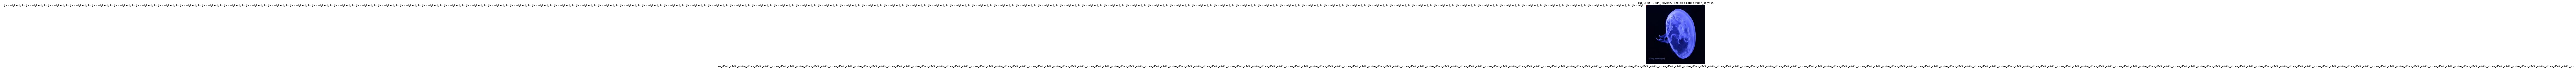

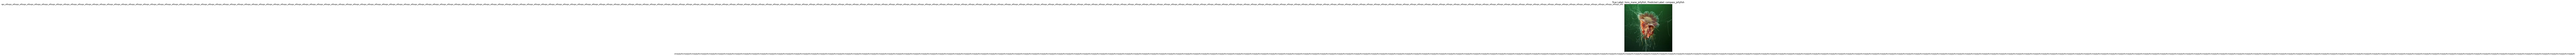

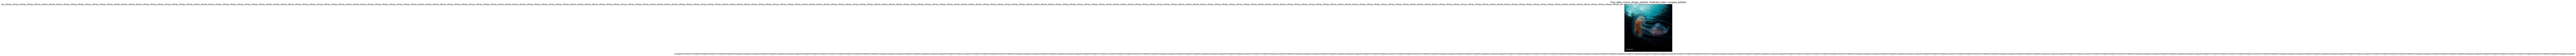

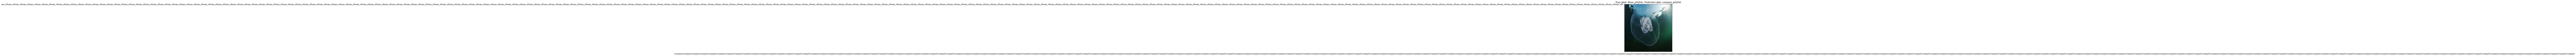

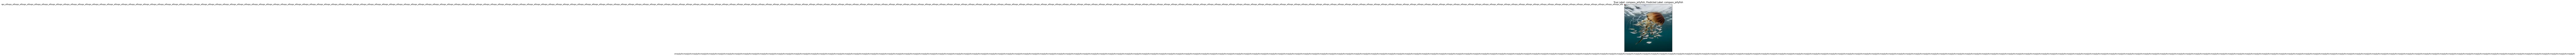

In [305]:
# Extract true labels from the DataFrame
true_labels = test_df['label'].tolist()

# Visualize Predictions
for i in range(min(5, len(test_images))):
    visualize_prediction(test_images[i][0], true_labels[i], predicted_labels[i])

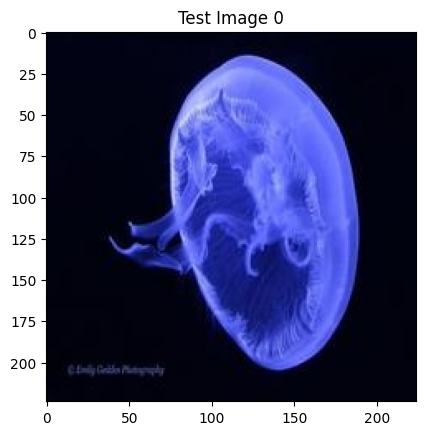

In [297]:
# Assuming 'test_images' is the list of preprocessed test images
plt.imshow(test_images[0][0])  # Display the first image in the list
plt.title('Test Image 0')
plt.show()